# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


### Carga de datos

In [3]:
files_names = []
for filename in glob.glob("datos/precios/*"):
    files_names.append(filename)

In [4]:
files_names.sort()

In [5]:
precio_final = pd.read_excel(files_names[0],skiprows = 3)

In [6]:
for i in range(1,len(files_names)):    
    cont = 0    
    while(True):         
        precio_i = pd.read_excel(files_names[i],skiprows = cont).iloc[:,0:25]          
        if precio_i.columns[0] == 'Fecha':
            break
        elif cont >= 15:
            break
        else:
            cont+=1
    precio_final = pd.concat([precio_final,precio_i],ignore_index=True,axis=0) 

In [7]:
precio_final["Fecha"] = pd.to_datetime(precio_final["Fecha"])

In [8]:
precio_final = precio_final.sort_values(by=['Fecha'])

In [9]:
serie = pd.concat([precio_final["Fecha"],precio_final.mean(axis=1)],axis=1)

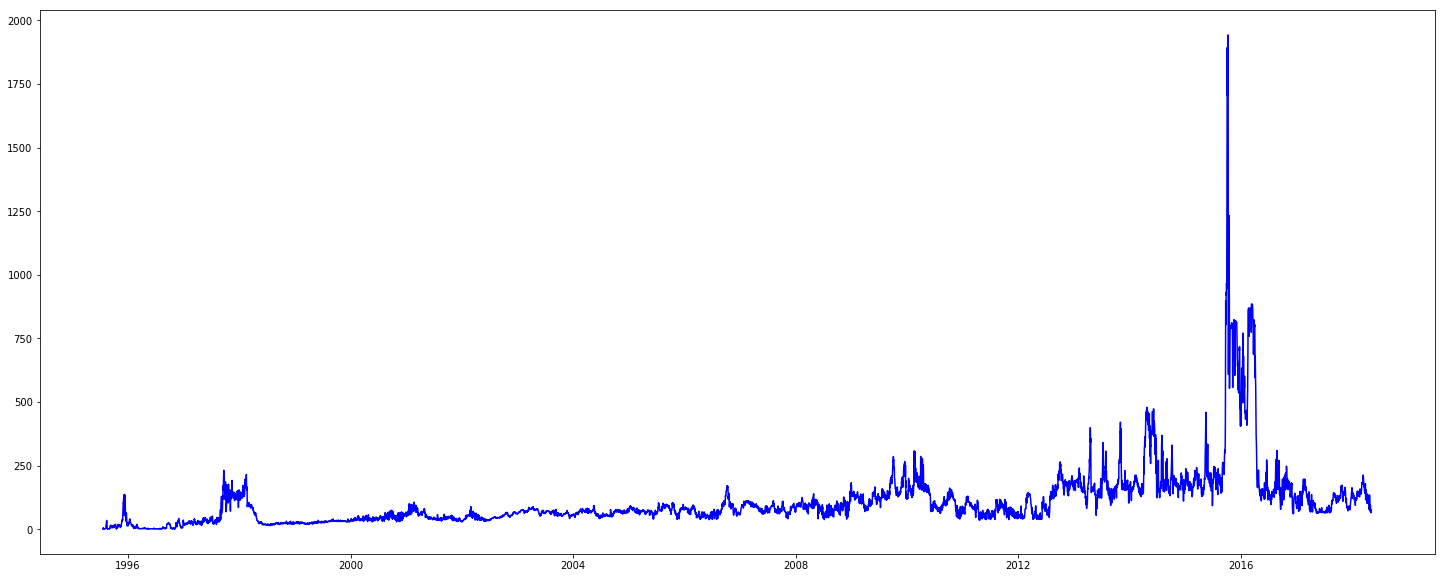

In [11]:
figure(num=None, figsize=(25,10), facecolor='w', edgecolor='k')
plt.plot(serie["Fecha"], serie.iloc[:,1],'b-')
plt.show()

In [12]:
serie = serie.dropna() 

In [13]:
serie = serie.reset_index(drop=True)

In [14]:
serie.columns = ["fecha","price"]

### Normalizo la serie

In [15]:
sc = MinMaxScaler(feature_range = (0, 1))

d = sc.fit_transform(serie["price"].values.reshape(-1,1)).reshape(-1,)

### Modelo Adaline

In [16]:
dias_a_predecir = 24*7

In [17]:
tf.enable_eager_execution()

In [19]:
class Model(object):
    def __init__(self, L):      
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

In [20]:
#### Se procede a encontrar el número de retardos más adecuado

In [21]:
# Nro de retardos a probar
retardos = [2,3,4,5,6,7,8,10]

def tuning_retardos(retardos,d):
    
    resultado_retardos = []

    for i in range(len(retardos)):

        L = retardos[i]

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])

        resultado_retardos.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_retardos

resultado_retardos = tuning_retardos(retardos,d)

In [22]:
menor_mse_retardos = []

for i in resultado_retardos:
   
    menor_mse_retardos.append(metrics.mean_squared_error(i[0],i[1]))

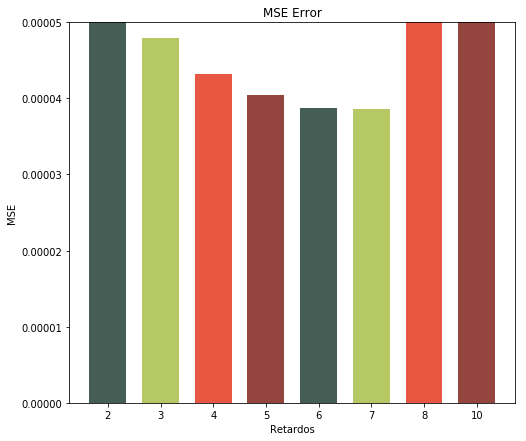

In [44]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,7))

plt.bar(["2","3","4","5","6","7","8","10"],[menor_mse_retardos[0],
                                           menor_mse_retardos[1],
                                           menor_mse_retardos[2],
                                           menor_mse_retardos[3],
                                           menor_mse_retardos[4],
                                           menor_mse_retardos[5],
                                           menor_mse_retardos[6],
                                           menor_mse_retardos[7],
                                           ],
                                                    width=0.7,  
                                                     alpha=0.9, 
                                                    color=['#304C43','#ADC252','#E6452C','#893129'])

plt.ylim(0,0.00005)
plt.xlabel("Retardos")
plt.ylabel("MSE")
ax.set_title('MSE Error')
plt.show()

In [45]:
## Se selecciona 7 retardos 

### Se va a seleccionar la tasa de aprendizaje

In [108]:
lr = [0.01,0.02,0.03,0.04,0.05,0.06,0.07]

In [109]:
def tuning_lr(lr,d):
    
    resultado_lr = []

    for i in range(len(lr)):    
        L = 6

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=lr[i], x=x, y_desired=d[t])

        resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_lr

resultado_lr = tuning_lr(lr,d)

In [110]:
menor_mse_lr = []

for i in resultado_lr:
   
    menor_mse_lr.append(metrics.mean_squared_error(i[0],i[1]))

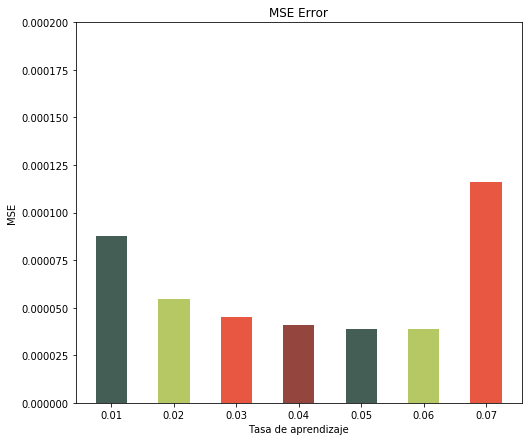

In [111]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,7))

plt.bar(["0.01","0.02","0.03","0.04","0.05","0.06","0.07"],[menor_mse_lr[0],
                                                            menor_mse_lr[1],
                                                            menor_mse_lr[2],
                                                            menor_mse_lr[3],
                                                            menor_mse_lr[4],
                                                            menor_mse_lr[5],
                                                            menor_mse_lr[6]],
                                                    width=0.5,  
                                                    alpha=0.9, 
                                                    color=['#304C43','#ADC252','#E6452C','#893129'])

plt.ylim(0,0.0002)
plt.xlabel("Tasa de aprendizaje")
plt.ylabel("MSE")
ax.set_title('MSE Error')
plt.show()

#### Se selecciona 0.05 por parsimonia

## Adaline con párametros óptimos

In [112]:
def adaline(L,lr,d):
    L = L

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr, x=x, y_desired=d[t])
    
    return [d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]]
    
modelo_sin_transf = adaline(7,0.05,d)


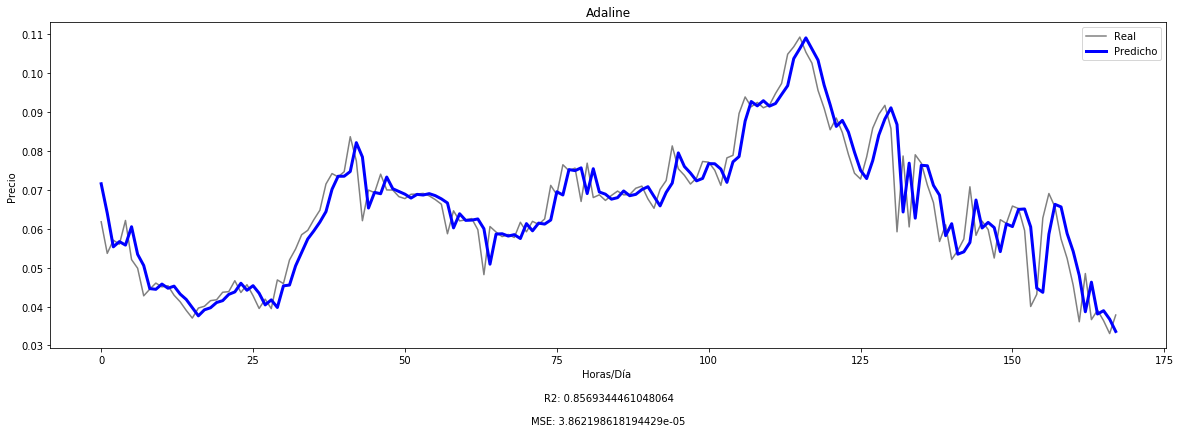

In [113]:
def graficar_modelo(real,pred,nombre):
    figure(figsize=(20,6))
    plt.plot(real, color = 'gray', label = 'Real')
    plt.plot(pred, color = 'blue', label = 'Predicho',linewidth= 3)
    plt.title(nombre)
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()


graficar_modelo(modelo_sin_transf[0],modelo_sin_transf[1],"Adaline")

### Transformaciones
 
 - Raiz Cuadrada
 - Logaritmo Natural

In [115]:
def evaluacion(resultados,parametros):  
    metricas = []
    
    for i in range(len(resultados)):
        
        real,pred = resultados[i][0],resultados[i][1]
        
        r2 = r2_score(real,pred)
        mse = metrics.mean_squared_error(real, pred)
        
        metricas.append([r2,mse])
     
    df = pd.DataFrame(metricas,parametros)
    
    return df.sort_values(by=[0],ascending=False).iloc[0]

### Raíz Cuadrada

In [116]:
serie_sqrt = sc.fit_transform(serie["price"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)

In [117]:
resultado_retardos_sqrt = tuning_retardos(retardos,serie_sqrt)

In [118]:
mejor_retardo_sqrt = evaluacion(resultado_retardos_sqrt,retardos)

In [119]:
mejor_retardo_sqrt

0    0.849737
1    0.000163
Name: 5, dtype: float64

In [120]:
resultado_lr_sqrt = tuning_lr(lr,serie_sqrt)

In [121]:
mejor_lr_sqrt = evaluacion(resultado_lr_sqrt,lr)

In [122]:
mejor_lr_sqrt

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

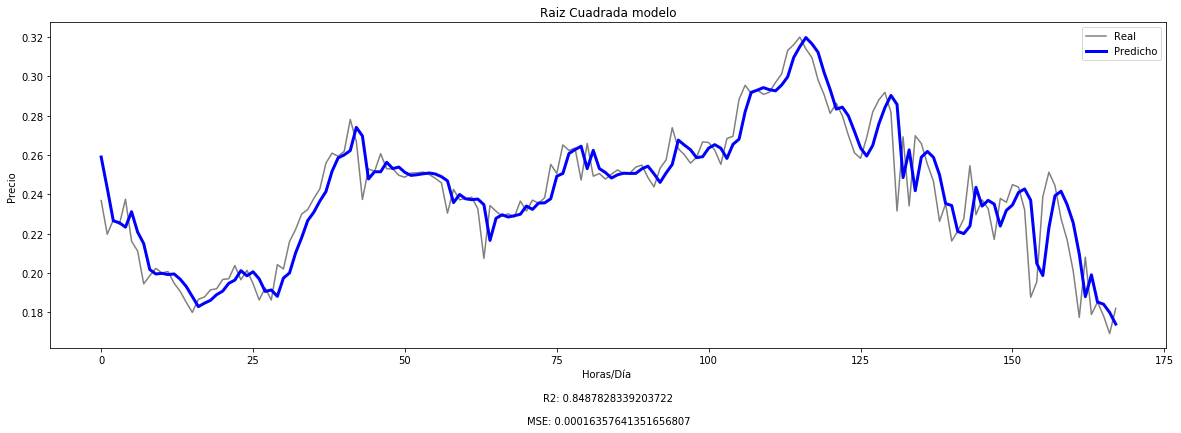

In [124]:
modelo_sqrt = adaline(5,0.04,serie_sqrt)
graficar_modelo(modelo_sqrt[0],modelo_sqrt[1],"Raiz Cuadrada modelo")

### Logaritmo natural 

In [125]:
serie_log = sc.fit_transform(np.array(serie["price"].apply(np.log).values).reshape(-1,1)).reshape(-1,)

In [126]:
resultado_retardos_log = tuning_retardos(retardos,serie_log)

In [127]:
mejor_retardo_log = evaluacion(resultado_retardos_log[:-3],retardos[:-3])

In [128]:
mejor_retardo_log

0    0.847960
1    0.000151
Name: 2, dtype: float64

In [64]:
resultado_lr_log = tuning_lr(lr,serie_log)

In [65]:
mejor_lr_log = evaluacion(resultado_lr_log[:-2],lr[:-2])

In [129]:
mejor_lr_sqrt

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

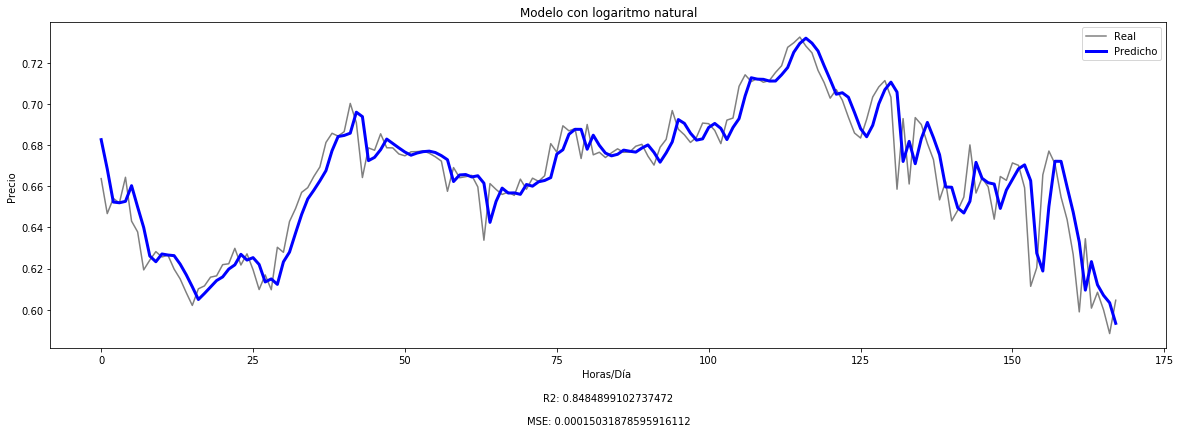

In [131]:
modelo_log = adaline(2,0.04,serie_log)

graficar_modelo(modelo_log[0],modelo_log[1],"Modelo con logaritmo natural")

#### Las transformaciones no mejoraron el resultado en este caso